In [1]:
from tensorflow.keras.models import load_model
from functions import margin_loss_fun_factory,DataGenerator,PredictGenerator,\
                        l2_distance_np,top_k,loop_distance,MAP,generate_feature,GridSearch,dot_distance_neg_np
import pickle
from albumentations import ShiftScaleRotate,Cutout,RandomContrast,RandomBrightness,Compose
from utility.albumentations_helper import create_transform
import time
import tensorflow as tf
import numpy as np
from functools import partial

In [53]:
## change ##
color = False
distance = l2_distance_np
FFA1_size,FFA2_size = 4,4
new_whale_count = 2416

Load model

In [3]:
feature_model = load_model('Models/feature_model_DenseNet_Triplet2.h5')

In [5]:
#feature_model = load_model('Models/feature_l2_distance_margin_loss_fun_factory(0.1,5).h5', \
#                            custom_objects={'loss': margin_loss_fun_factory(0.1,5)})

In [4]:
if color:
    with open('/home/will/Desktop/kaggle/Whale/train_df_color.pkl', 'rb') as f:
        Ids_train = pickle.load(f)
    with open('/home/will/Desktop/kaggle/Whale/new_whale_train_color.pkl', 'rb') as f:
        newWhale_train = pickle.load(f)
    with open('/home/will/Desktop/kaggle/Whale/val_df_color.pkl', 'rb') as f:
        Ids_val = pickle.load(f)
    with open('/home/will/Desktop/kaggle/Whale/new_whale_val_color.pkl', 'rb') as f:
        newWhale_val = pickle.load(f)
else:
    with open('/home/will/Desktop/kaggle/Whale/train_df.pkl', 'rb') as f:
        Ids_train = pickle.load(f)
    with open('/home/will/Desktop/kaggle/Whale/new_whale_train.pkl', 'rb') as f:
        newWhale_train = pickle.load(f)
    with open('/home/will/Desktop/kaggle/Whale/val_df.pkl', 'rb') as f:
        Ids_val = pickle.load(f)
    with open('/home/will/Desktop/kaggle/Whale/new_whale_val.pkl', 'rb') as f:
        newWhale_val = pickle.load(f)

In [5]:
aug = Compose([RandomContrast(p=0.2),RandomBrightness(p=0.2),
                ShiftScaleRotate(shift_limit=0.03,rotate_limit=15,scale_limit=0.02,p=1)])
transform = create_transform(aug)    

In [8]:
val_list = [[sublist[np.random.randint(len(sublist))]] for sublist in Ids_val.Imgs.tolist()]

In [14]:
newWale_list = val_list + [[item] for item in newWhale_val]

In [19]:
feature_train = generate_feature(Ids_train,transform,FFA1_size,color,feature_model)[:,:,np.newaxis,:]
feature_val = generate_feature(newWale_list,transform,FFA2_size,color,feature_model)

In [154]:
d_diag = distance(feature_train,np.swapaxes(feature_train,1,2))
d_diag = np.reshape(d_diag,(d_diag.shape[0],-1))
d_diag = np.sort(d_diag,1)
d_diag = np.min(d_diag[:,4:],1)

In [84]:
distance_list = []
for feature in feature_val:
    feature = feature[np.newaxis,np.newaxis,:,:]
    distance_list.append(distance(feature_train,feature))
distance_matrix = np.array(distance_list)

In [85]:
distance_matrix = np.reshape(distance_matrix,(distance_matrix.shape[0],-1))

In [86]:
distance_matrix = np.sort(distance_matrix,axis=1)

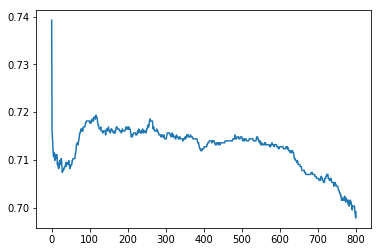

In [87]:
# every 100 points
distance_index = np.argsort(distance_matrix[:,::100],0)
plt.plot(np.sum(distance_index[-new_whale_count:]>len(val_list),0)/new_whale_count)

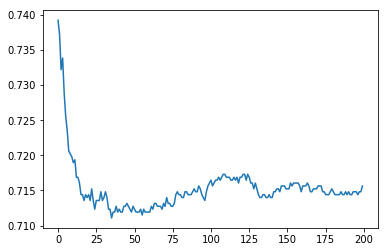

In [88]:
# first 200 points
distance_index = np.argsort(distance_matrix[:,:200],0)
plt.plot(np.sum(distance_index[-new_whale_count:]>len(val_list),0)/new_whale_count)

Subtract class mean

In [158]:
distance_matrix = np.array(distance_list)

In [159]:
distance_matrix = distance_matrix - d_diag[np.newaxis,:,np.newaxis,np.newaxis]

In [160]:
distance_matrix = np.reshape(distance_matrix,(distance_matrix.shape[0],-1))

In [161]:
distance_matrix = np.sort(distance_matrix,axis=1)

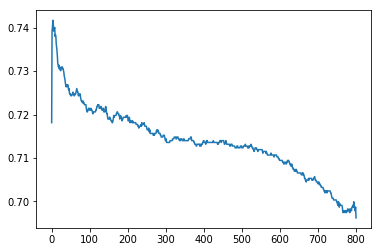

In [162]:
# every 100 points
distance_index = np.argsort(distance_matrix[:,::100],0)
plt.plot(np.sum(distance_index[-new_whale_count:]>len(val_list),0)/new_whale_count)

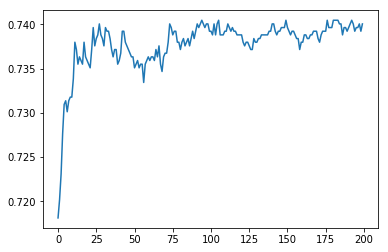

In [163]:
# first 200 points
distance_index = np.argsort(distance_matrix[:,:200],0)
plt.plot(np.sum(distance_index[-new_whale_count:]>len(val_list),0)/new_whale_count)

Re-do with TTA = 2

In [78]:
TTA = 2

In [79]:
distance_list = []
for feature in feature_val:
    feature = feature[np.newaxis,np.newaxis,:TTA,:]
    distance_list.append(distance(feature_train[:,:TTA,:,:],feature))
distance_matrix = np.array(distance_list)

In [80]:
distance_matrix = np.reshape(distance_matrix,(distance_matrix.shape[0],-1))

In [81]:
distance_matrix = np.sort(distance_matrix,axis=1)

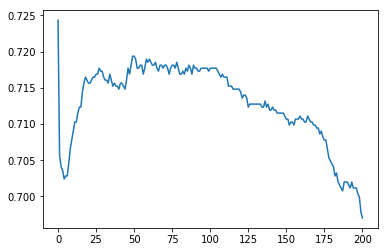

In [82]:
# every 100 points
distance_index = np.argsort(distance_matrix[:,::100],0)
plt.plot(np.sum(distance_index[-new_whale_count:]>len(val_list),0)/new_whale_count)

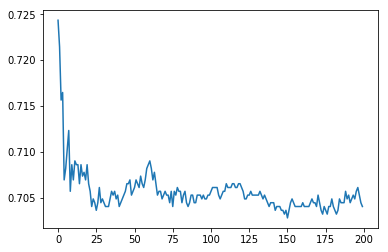

In [83]:
# first 200 points
distance_index = np.argsort(distance_matrix[:,:200],0)
plt.plot(np.sum(distance_index[-new_whale_count:]>len(val_list),0)/new_whale_count)